In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint_adjoint as odeint

import os
import sys

import IPython.display as dp
import matplotlib.pyplot as plt
import seaborn as sns

dp.set_matplotlib_formats('retina')
sns.set_style('whitegrid')
sns.despine()

%matplotlib notebook

## Neural ODE

In [2]:
def get_initial_values(P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
    """
    Initializes generator state vector `x` and network terminal variables vector `V`
    in machine base from given power flow values in system base and angle in radians.
    """
    
    # unpack parameters guess
    ws = 1
    KD = 0
    ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta0
    
    # define transforms
    
    # vf_MB = vf * Vb / Vn
    wb = 2 * np.pi * fn
    S_SBtoMB = Sb / Sn
    V_MBtoSB = Vn / Vb
    I_MBtoSB = Sn * Vb / (Sb * Vn)
    Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)
    
    # initialize stator quantitites
    
    p0 = P0 / Sb
    q0 = Q0 / Sb
    Vt0 = V0 * np.exp(1j * angle0)
    S0 = p0 - 1j * q0
    I0 = S0 / Vt0.conjugate()
    vr0 = Vt0.real
    vi0 = Vt0.imag
    ir0 = -I0.real
    ii0 = -I0.imag
    
    # initialize DQ-quantities
    
    w0 = 1
    delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)
    
    Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    
    vd0 = Vdq0.real
    vq0 = Vdq0.imag
    id0 = Idq0.real
    iq0 = Idq0.imag
    
    # initialize order 3
    
    e1q0 = vq0 + ra * iq0 + x1d * id0
    
    # initialize AVR
    
    v = np.abs(Vt0)
    vref = v
    vs0 = 0
    vm0 = v
    vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
    vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)
    
    # initialize PSS
    
    v20 = 0
    
    # constants
    
    pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
    vsmin, vsmax = -0.2, 0.2
    vfmin, vfmax = -6.4, 7
    
    # pack values
    
    x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
    V = np.array([vd0, vq0, id0, iq0])
    c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb, KD])
    
    return x, V, c, (p0, q0)

In [23]:
class RHSTrue(nn.Module):
    def __init__(self, v, c, t):
        super(RHSTrue, self).__init__()
        
        self.theta = torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                10., 10., 0.05, 0.02, 0.015, 1.,
                                                1., 0.0001, 200]))
        self.c = c
        self.vt = lambda x: np.interp(x, t, v[:, 0])
        self.phi = lambda x: np.interp(x, t, v[:, 1])
        
    def forward(self, t, x):
        v = torch.tensor([self.vt(t), self.phi(t)])

        vd = v[0] * torch.sin(x[0] - v[1])
        vq = v[0] * torch.cos(x[0] - v[1])

        id = (self.theta[3] * x[7] - self.theta[3] * vq - self.theta[0] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)
        iq = (self.theta[0] * x[7] - self.theta[0] * vq + self.theta[1] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)

        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.theta[0] * iq) * iq + (vd + self.theta[0] * id) * id

        return torch.tensor([
            self.c[8] * (x[1] - 1),
            (self.c[0] - pe) / (2 * self.theta[4]),
            self.theta[6] * (self.c[0] - pe) / (2 * self.theta[4]) - x[2] / self.theta[7],
            (self.theta[8] * (self.theta[6] * (self.c[0] - pe)
                              / (2 * self.theta[4]) - x[2]
                              / self.theta[7]) + x[2] - x[3]) / self.theta[9],
            (v[0] - x[4]) / self.theta[10],
            (self.theta[14] * (1 - self.theta[11] / self.theta[12]) * (self.c[5] + x[3] - x[4]) - x[5]) / self.theta[12],
            ((x[5] + self.theta[14] * self.theta[11] * (self.c[5] + x[3] - x[4])
              / self.theta[12] + self.c[6]) * (1 + self.c[7] * (v[0] / x[4] - 1)) - x[6]) / self.theta[13],
            (- x[7] - (self.theta[2] - self.theta[1]) * id + x[6]) / self.theta[5]
        ], requires_grad=True)

In [30]:
class RHS(nn.Module):
    def __init__(self, v, c, t):
        super(RHS, self).__init__()
        
        self.theta = nn.Parameter(torch.rand(15))
        self.s = torch.from_numpy(np.array([0.01, 1., 10., 10., 10., 10.,
                                            10., 10., 0.1, 0.1, 0.1, 1.,
                                            1., 0.001, 1000]))
        self.c = c
        self.vt = lambda x: np.interp(x.detach().numpy(), t.detach().numpy(), v[:, 0])
        self.phi = lambda x: np.interp(x.detach().numpy(), t.detach().numpy(), v[:, 1])
        
    def forward(self, t, x):
        v = torch.tensor([self.vt(t), self.phi(t)])

        vd = v[0] * torch.sin(x[0] - v[1])
        vq = v[0] * torch.cos(x[0] - v[1])

        id = (self.s[3] * self.theta[3] * x[7] - self.s[3] * self.theta[3] * vq - self.s[0] * self.theta[0] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        iq = (self.s[0] * self.theta[0] * x[7] - self.s[0] * self.theta[0] * vq + self.s[1] * self.theta[1] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)

        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.s[0] * self.theta[0] * iq) * iq + (vd + self.s[0] * self.theta[0] * id) * id

        return torch.tensor([
            self.c[8] * (x[1] - 1),
            (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]),
            self.s[6] * self.theta[6] * (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]) - x[2] / (self.s[7] * self.theta[7]),
            (self.s[8] * self.theta[8] * (self.s[6] * self.theta[6] * (self.c[0] - pe)
                              / (2 * self.s[4] * self.theta[4]) - x[2]
                              / (self.s[7] * self.theta[7])) + x[2] - x[3]) / (self.s[9] * self.theta[9]),
            (v[0] - x[4]) / (self.s[10] * self.theta[10]),
            (self.s[14] * self.theta[14] * (1 - self.s[11] * self.theta[11] / (self.s[12] * self.theta[12])) * (self.c[5] + x[3] - x[4]) - x[5]) / (self.s[12] * self.theta[12]),
            ((x[5] + self.s[14] * self.theta[14] * self.s[11] * self.theta[11] * (self.c[5] + x[3] - x[4])
              / (self.s[12] * self.theta[12]) + self.c[6]) * (1 + self.c[7] * (v[0] / x[4] - 1)) - x[6]) / (self.s[13] * self.theta[13]),
            (- x[7] - (self.s[2] * self.theta[2] - self.s[1] * self.theta[1]) * id + x[6]) / (self.s[5] * self.theta[5])
        ], requires_grad=True)

In [25]:
data_size = 60001
batch_time = 5000
batch_size = 1
t = torch.linspace(0, 6, steps=data_size)
# df = pd.read_csv('./exportedVariables.csv')
df = pd.read_csv('./exportedVariables2.csv')
df = df.drop_duplicates('time')
df = df.drop(['time'], axis=1)
# df.columns = ['p', 'q', 'v', 'phi']
df.columns = ['v', 'vm', 'vr', 'p', 'q', 'phi', 'delta',
              'e1q', 'id', 'iq', 'ii', 'ir', 'vi', 'vrr',
              'vd', 'vf', 'vq', 'w', 'vs']
df = df.drop(['ii', 'ir', 'vi', 'vrr', 'vd', 'vq', 'id', 'iq'], axis=1)
df.phi = df.phi * np.pi / 180
v = df[['v', 'phi']].values
x0, v0, c, (p0, q0) = get_initial_values(P0=1997.9999999936396,
                                         Q0=967.9249699065775,
                                         V0=1.0,
                                         angle0=0.494677176989154,
                                         theta0=np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                          10., 10., 0.05, 0.02, 0.015, 1.,
                                                          1., 0.0001, 200]))
with torch.no_grad():
    rhs_true = RHSTrue(v, c, t)
    true_y = odeint(rhs_true, torch.from_numpy(x0), t, method='euler')

In [26]:
def get_batch_size_one():
    s = np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), replace=False)
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[s:s+batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[s:s+batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [33]:
rhs = RHS(v, c, t)
rhs.double()
optimizer = optim.RMSprop(rhs.parameters())
for iter_n in range(100):
    theta_prev = rhs.theta.clone()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch_size_one()
    pred_y = odeint(rhs, batch_y0, batch_t, method='euler')
    loss = torch.sum(torch.pow(pred_y - batch_y, 2))
    loss.backward()
    optimizer.step()
    reference = (rhs.theta - torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                        10., 10., 0.05, 0.02, 0.015, 1.,
                                                        1., 0.0001, 200])) / rhs.s).pow(2).sum().sqrt().item()
    dist = (rhs.theta - theta_prev).pow(2).sum().sqrt().item()
    print('[%04d]\tloss\t%e\tdistance to solution\t%e\tdistance to prev\t%e' % (iter_n, loss.item(), reference, dist))

tensor(0., dtype=torch.float64)


## Solver

In [3]:
def transition(x, v, c, theta, tau=1e-4):
    delta, w, v2, vs, vm, vr, vf, e1q = x
    vt, phi = v
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (xq * e1q - xq * vq - ra * vd) / (x1d * xq + ra ** 2)
    iq = (ra * e1q - ra * vq + x1d * vd) / (x1d * xq + ra ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    
    xnew = x + tau * np.array([
        wb * (w - ws),
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])
    
    xnew[3] = max(vsmin, min(vsmax, xnew[3]))
    xnew[6] = max(vfmin, min(vfmax, xnew[6]))
    
    return xnew, (p, q)

In [4]:
df = pd.read_csv('./exportedVariables.csv')
df = df.drop_duplicates('time')
t = df.time.values
df = df.drop(['time'], axis=1)
df.columns = ['p', 'q', 'v', 'phi']
df.phi = df.phi * np.pi / 180

## Learner

In [6]:
len(t)

50001

In [60]:
class Learner():
    def __init__(self, injections, theta_true, stepsize=None, eta=1., steps=1e2,
                 eps=1e-3, tau=1e-4, mu=1e2, c1=1e-4, c2=1e-1, lbd=1.):
        self.injections = injections
        self.theta_true = theta_true
        self.stepsize = stepsize if stepsize is not None else lambda x: 1
        self.steps = steps
        self.eta = eta
        self.eps = eps
        self.tau = tau
        self.mu = mu
        self.c1 = c1
        self.c2 = c2
        self.lbd = lbd
        
        # ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0
        self.s_ws = 10.
        self.s_ra = 0.01
        self.s_x1d = 1.
        self.s_xd = 10.
        self.s_xq = 10.
        self.s_H = 10.
        self.s_KD = 1.
        self.s_T1d0 = 10.
        self.s_Kw = 10.
        self.s_Tw = 10.
        self.s_Tpss1 = 0.1
        self.s_Tpss2 = 0.1
        self.s_Tr = 0.1
        self.s_Tavr1 = 1.
        self.s_Tavr2 = 1.
        self.s_Te = 0.001
        self.s_K0 = 1000
        
        self.theta = None
    
    def load_injection(self):
        fname = np.random.choice(self.injections)
        df = pd.read_csv(fname).drop_duplicates('t').drop(['t'], axis=1)
        df.phi = df.phi * np.pi / 180
        return df[['p', 'q']].values, df[['v', 'phi']].values
    
    def transition(self, x, v, c):
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (self.s_xq * xq * e1q - self.s_xq * xq * vq - self.s_ra * ra * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        iq = (self.s_ra * ra * e1q - self.s_ra * ra * vq + self.s_x1d * x1d * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)

        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)

        xnew = x + self.tau * np.array([
            wb * (w - self.s_ws * ws),
            self.s_ws * ws * (pm - (vq + self.s_ra * ra * iq) * iq - (vd + self.s_ra * ra * id) * id - self.s_KD * KD * (w / (self.s_ws * ws) - 1)) / (2 * self.s_H * H),
            self.s_Kw * Kw * self.s_ws * ws * (pm - (vq + self.s_ra * ra * iq) * iq - (vd + self.s_ra * ra * id) * id - self.s_KD * KD * (w / (self.s_ws * ws) - 1)) / (2 * self.s_H * H) - v2 / (self.s_Tw * Tw),
            (self.s_Tpss1 * Tpss1 * (self.s_Kw * Kw * self.s_ws * ws * (pm - (vq + self.s_ra * ra * iq) * iq - (vd + self.s_ra * ra * id) * id \
                                 - self.s_KD * KD * (w / (self.s_ws * ws) - 1)) / (2 * self.s_H * H) - v2 / (self.s_Tw * Tw)) + v2 - vs) / (self.s_Tpss2 * Tpss2),
            (vt - vm) / (self.s_Tr * Tr),
            (self.s_K0 * K0 * (1 - self.s_Tavr1 * Tavr1 / (self.s_Tavr2 * Tavr2)) * (vref + vs - vm) - vr) / (self.s_Tavr2 * Tavr2),
            ((vr + self.s_K0 * K0 * self.s_Tavr1 * Tavr1 * (vref + vs - vm) / (self.s_Tavr2 * Tavr2) + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / (self.s_Te * Te),
            (- e1q - (self.s_xd * xd - self.s_x1d * x1d) * id + vf) / (self.s_T1d0 * T1d0)
        ])

        xnew[3] = max(vsmin, min(vsmax, xnew[3]))
        xnew[6] = max(vfmin, min(vfmax, xnew[6]))

        return xnew, (p, q)
        
    def solve(self, src):
        x0, v0, c, pq0 = get_initial_values(P0=1997.9999999936396,
                                           Q0=967.9249699065775,
                                           V0=1.0,
                                           angle0=0.494677176989154,
                                           theta0=self.theta)
        
        xs = [x0]
        vs = [v0]
        pqs = [pq0]
        for t in range(1, len(src)):
            x, pq = self.transition(xs[-1], src[t], c)
            xs.append(x)
            pqs.append(pq)
            
        return xs, pqs, c
    
    def grad_dSdV(self, x, v, c):
        """
        Compute gradient dS_t/dV_t of size dimV x dimS
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        grad = np.array([
            [22.2 * vd, 22.2 * vq],
            [22.2 * vq, - 22.2 * vd]
        ])
        
        return grad
    
    def grad_dSdX(self, x, v, c):
        """
        Compute gradient dS_t/dX_t of size dimX x dimS
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)
        
        id = (self.s_xq * xq * e1q - self.s_xq * xq * vq - self.s_ra * ra * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        iq = (self.s_ra * ra * e1q - self.s_ra * ra * vq + self.s_x1d * x1d * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        
        g1 = 22.2 * (vq * id - vd * iq)
        g2 = 22.2 * (- vd * id - vq * iq)
        
        grad = np.array([
            [g1, g2],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0]
        ])
        
        return grad
        
    def grad_dVdX(self, x, v, c):
        """
        Compute gradient dV_t/dX_t of size dimX x dimV
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v
        
        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)
        
        denom = self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2
        
        g1 = (self.s_xq * xq * vd - self.s_ra * ra * vq) / denom
        g2 = (self.s_ra * ra * vd + self.s_x1d * x1d * vq) / denom
        
        grad = np.array([
            [g1, g2],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [self.s_xq * xq / denom, self.s_ra * ra / denom]
        ])
        
        return grad
        
    def grad_dVdP(self, x, v, c):
        """
        Compute gradient dV_t/dP of size dimP x dimV
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (self.s_xq * xq * e1q - self.s_xq * xq * vq - self.s_ra * ra * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        iq = (self.s_ra * ra * e1q - self.s_ra * ra * vq + self.s_x1d * x1d * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        
        denom = self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2
        
        j1 = self.s_ra * (- vd * self.s_x1d * x1d * self.s_xq * xq - self.s_xq * xq * e1q * 2 * self.s_ra * ra + 2 * self.s_ra * ra * xq * self.s_xq * vq + vd * (self.s_ra * ra) ** 2) / denom ** 2
        j2 = self.s_ra * (e1q * self.s_x1d * x1d * self.s_ra * xq - vq * self.s_x1d * x1d * self.s_ra * xq - (self.s_ra * ra) ** 2 * e1q + (self.s_ra * ra) ** 2 * vq - 2 * self.s_ra * ra * self.s_x1d * x1d * vd) / denom ** 2
        j3 = - self.s_x1d * self.s_xq * xq * (xq * e1q - xq * vq - ra * vd) / denom ** 2
        j4 = self.s_x1d * (vd * (self.s_ra * ra) ** 2 - self.s_xq * xq * self.s_ra * ra * e1q + self.s_xq * xq * self.s_ra * ra * vq) / denom ** 2
        j5 = self.s_xq * (e1q * (self.s_ra * ra) ** 2 - vq * (self.s_ra * ra) ** 2 + self.s_x1d * x1d * self.s_ra * ra * vd) / denom ** 2
        j6 = - self.s_xq * self.s_x1d * x1d * (self.s_ra * ra * e1q - self.s_ra * ra * vq + self.s_x1d * x1d * vd) / denom ** 2
        
        grad = np.array([
            [0, 0],
            [j1, j2],
            [j3, j4],
            [0, 0],
            [j5, j6],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0]
        ])
        
        return grad
        
    def grad_dXdV(self, x, v, c):
        """
        Compute gradient dX_t/dV_t of size dimV x dimX
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (self.s_xq * xq * e1q - self.s_xq * xq * vq - self.s_ra * ra * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        iq = (self.s_ra * ra * e1q - self.s_ra * ra * vq + self.s_x1d * x1d * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        
        g1 = - (vd + 2 * self.s_ra * ra * id) * self.s_ws * ws / (2 * self.s_H * H)
        g2 = self.s_Kw * Kw * g1
        g3 = self.s_Tpss1 * Tpss1 * g2 / (self.s_Tpss2 * Tpss2)
        g4 = - (self.s_xd * xd - self.s_x1d * x1d) / (self.s_T1d0 * T1d0)
        g5 = - (vq + 2 * self.s_ra * ra * iq) * self.s_ws * ws / (2 * self.s_H * H)
        g6 = self.s_Kw * Kw * g5
        g7 = self.s_Tpss1 * Tpss1 * g6 / (self.s_Tpss2 * Tpss2)
        
        grad = self.tau * np.array([ # VxX
            [0, g1, g2, g3, 0, 0, 0, g4],
            [0, g5, g6, g7, 0, 0, 0, 0],
        ])
        
        return grad
    
    def grad_dXdX(self, x, v, c):
        """
        Compute gradient dX_t/dX_{t-1} of size dimX x dimX
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v
        
        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (self.s_xq * xq * e1q - self.s_xq * xq * vq - self.s_ra * ra * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        iq = (self.s_ra * ra * e1q - self.s_ra * ra * vq + self.s_x1d * x1d * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        
        g0 = self.s_ws * ws * (vd * iq - vq * id) / (2 * self.s_H * H)
        g00 = self.s_Kw * Kw * g0
        g000 = self.s_Tpss1 * Tpss1 * g00 / (self.s_Tpss2 * Tpss2)
        g1 = - self.s_KD * KD / (2 * self.s_H *  H)
        g2 = self.s_Kw * Kw * g1
        g3 = self.s_Tpss1 * Tpss1 * g2 / (self.s_Tpss2 * Tpss2)
        g4 = -1 / (self.s_Tw * Tw)
        g5 = self.s_Tpss1 * Tpss1 * g4 / (self.s_Tpss2 * Tpss2) + 1 / (self.s_Tpss2 * Tpss2)
        g6 = self.s_K0 * K0 * (1 - self.s_Tavr1 * Tavr1 / (self.s_Tavr2 * Tavr2)) / (self.s_Tavr2 * Tavr2)
        g7 = self.s_K0 * K0 * self.s_Tavr1 * Tavr1 * (1 + s0 * (vt / vm - 1)) / (self.s_Te * Te * self.s_Tavr2 * Tavr2)
        g8 = (1 + s0 * (vt / vm - 1)) / (self.s_Te * Te)
        g9 = - g7 - (vr + self.s_K0 * K0 * self.s_Tavr1 * Tavr1 * (vref + vs - vm) / (self.s_Tavr2 * Tavr2)) * s0 * vt / (self.s_Te * Te * vm ** 2)
        
        grad = np.eye(8) + self.tau * np.array([
            # ddelta/ dw/ dv2/ dvs/ dvm/ dvr/ dvf/ de1q/
            [0, g0, g00, g000, 0, 0, 0, 0], # /ddelta
            [wb, g1, g2, g3, 0, 0, 0, 0], # /dw
            [0, 0, g4, g5, 0, 0, 0, 0], # /dv2
            [0, 0, 0, -1/(self.s_Tpss2 * Tpss2), 0, g6, g7, 0], # /dvs
            [0, 0, 0, 0, -1/(self.s_Tr * Tr), -g6, g9, 0], # /dvm
            [0, 0, 0, 0, 0, -1/(self.s_Tavr2 * Tavr2), g8, 0], # /dvr
            [0, 0, 0, 0, 0, 0, -1/(self.s_Te * Te), 1/(self.s_T1d0 * T1d0)], # /dvf
            [0, 0, 0, 0, 0, 0, 0, -1/(self.s_T1d0 * T1d0)] # /de1d
        ])
        
        return grad
        
    def grad_dXdP(self, x, v, c):
        """
        Compute gradient dX_t/dP of size dimP x dimX
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD = c
        ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.theta
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (self.s_xq * xq * e1q - self.s_xq * xq * vq - self.s_ra * ra * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        iq = (self.s_ra * ra * e1q - self.s_ra * ra * vq + self.s_x1d * x1d * vd) / (self.s_x1d * x1d * self.s_xq * xq + (self.s_ra * ra) ** 2)
        
        g0 = - wb
        g1 = (pm - (vq + self.s_ra * ra * iq) * iq - (vd + self.s_ra * ra * id) * id + self.s_KD * KD) / (2 * self.s_H * H)
        g2 = - self.s_ws * ws * (iq ** 2 + id ** 2) / (2 * self.s_H * H)
        g3 = - self.s_ws * ws * (pm - (vq + self.s_ra * ra * iq) * iq - (vd + self.s_ra * ra * id) * id - self.s_KD * KD * (w / self.s_ws * ws - 1)) / (2 * (self.s_H * H) ** 2)
        g4 = - self.s_ws * ws * (w / (self.s_ws * ws) - 1) / (2 * self.s_H * H)
        g5 = self.s_Kw * Kw * g1
        g6 = self.s_Kw * Kw * g2
        g7 = self.s_Kw * Kw * g3
        g8 = self.s_Kw * Kw * g4
        g9 = self.s_ws * ws * (pm - (vq + self.s_ra * ra * iq) * iq - (vd + self.s_ra * ra * id) * id - self.s_KD * KD * (w / (self.s_ws * ws) - 1)) / (2 * self.s_H * H)
        g10 = v2 / ((self.s_Tw * Tw) ** 2)
        g11 = g5 * self.s_Tpss1 * Tpss1 / (self.s_Tpss2 * Tpss2)
        g12 = g6 * self.s_Tpss1 * Tpss1 / (self.s_Tpss2 * Tpss2)
        g13 = g7 * self.s_Tpss1 * Tpss1 / (self.s_Tpss2 * Tpss2)
        g14 = g8 * self.s_Tpss1 * Tpss1 / (self.s_Tpss2 * Tpss2)
        g15 = g9 * self.s_Tpss1 * Tpss1 / (self.s_Tpss2 * Tpss2)
        g16 = g10 * self.s_Tpss1 * Tpss1 / (self.s_Tpss2 * Tpss2)
        g17 = (self.s_Kw * Kw * g9 - v2 / (self.s_Tw * Tw)) / (self.s_Tpss2 * Tpss2)
        g18 = - (self.s_Tpss1 * Tpss1 * (self.s_Kw * Kw * g9 - v2 / (self.s_Tw * Tw)) + v2 - vs) / ((self.s_Tpss2 * Tpss2) ** 2)
        g19 = - (vt - vm) / ((self.s_Tr * Tr) ** 2)
        g20 = - self.s_K0 * K0 * (vref + vs - vm) / ((self.s_Tavr2 * Tavr2) ** 2)
        g21 = - (1 / (self.s_Tavr2 * Tavr2) ** 2) * (self.s_K0 * K0 * (1 - self.s_Tavr1 * Tavr1 / (self.s_Tavr2 * Tavr2)) * (vref + vs - vm) - vr) - K0 * (self.s_Tavr1 * Tavr1/((self.s_Tavr2 * Tavr2)**3)) * (vref + vs - vm)
        g22 = (1 - self.s_Tavr1 * Tavr1 / (self.s_Tavr2 * Tavr2)) * (vref + vs - vm) / (self.s_Tavr2 * Tavr2)
        g23 = self.s_K0 * K0 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (self.s_Tavr2 * Tavr2 * self.s_Te * Te)
        g24 = - self.s_K0 * K0 * self.s_Tavr1 * Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (self.s_Te * Te * (self.s_Tavr2 * Tavr2) ** 2)
        g25 = - ((vr + self.s_K0 * K0 * self.s_Tavr1 * Tavr1 * (vref + vs - vm) / (self.s_Tavr2 * Tavr2) + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / ((self.s_Te * Te) ** 2)
        g26 = self.s_Tavr1 * Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (self.s_Te * Te * self.s_Tavr2 * Tavr2)
        g27 = id / (self.s_T1d0 * T1d0)
        g28 = - g27
        g29 = - (- e1q - (self.s_xd * xd - self.s_x1d * x1d) * id + vf) / ((self.s_T1d0 * T1d0) ** 2)

        grad = self.tau * np.array([
            [self.s_ws * g0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [self.s_ws * g1, self.s_ra * g2, 0, 0, 0, self.s_H * g3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [self.s_ws * g5, self.s_ra * g6, 0, 0, 0, self.s_H * g7, 0, self.s_Kw * g9, self.s_Tw * g10, 0, 0, 0, 0, 0, 0, 0],
            [self.s_ws * g11, self.s_ra * g12, 0, 0, 0, self.s_H * g13, 0, self.s_Kw * g15, self.s_Tw * g16, self.s_Tpss1 * g17, self.s_Tpss2 * g18, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, self.s_Tr * g19, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, self.s_Tavr1 * g20, self.s_Tavr2 * g21, 0, self.s_K0 * g22],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, self.s_Tavr1 * g23, self.s_Tavr2 * g24, self.s_Te * g25, self.s_K0 * g26],
            [0, 0, self.s_x1d * g27, self.s_xd * g28, 0, 0, self.s_T1d0 * g29, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ]).T
        
        return grad
    
    def barrier(self):
        rv = np.where(self.theta > 0, - np.log(self.theta), np.inf)
        return np.sum(rv)
    
    def barrier_grad(self):
        rv = np.where(self.theta > 0, - 1/self.theta, 0)
        return rv
        
    def objective(self, pqs, dst):
        rv = 0.5 * np.mean(np.sum((pqs - dst) ** 2, axis=1)) + self.mu * self.barrier()
        # rv = np.log(1 + np.sum(self.lbd * np.exp(0.5 * np.sum((pqs[3:] - dst[3:]) ** 2, axis=1)))) / self.lbd
        return rv
    
    def objective_grad_once(self, v_t, v_tm1, v_tm2, x_tm1, x_tm2, x_tm3, c):
        grad_dX = self.grad_dXdP(x_tm2, v_tm1, c)
        grad_dX += self.grad_dVdP(x_tm2, v_tm1, c) @ self.grad_dXdV(x_tm2, v_tm1, c)
        grad_dX += self.grad_dXdP(x_tm3, v_tm2, c) @ self.grad_dXdX(x_tm2, v_tm1, c)
        grad_dV = self.grad_dVdP(x_tm1, v_t, c) + grad_dX @ self.grad_dVdX(x_tm1, v_t, c)
        grad_dS = grad_dX @ self.grad_dSdX(x_tm1, v_t, c) + grad_dV @ self.grad_dSdV(x_tm1, v_t, c)
        return grad_dS
    
    def objective_grad(self, x_sol, src, pqs, dst, c):
        jacs = [
            self.objective_grad_once(v_t, v_tm1, v_tm2, x_tm1, x_tm2, x_tm3, c) \
            for i, (v_t, v_tm1, v_tm2, x_tm1, x_tm2, x_tm3) \
            in enumerate(zip(src[3:], src[2:], src[1:], x_sol[2:], x_sol[1:], x_sol))
        ]
        
        rv = np.array([pair @ jac.T for jac, pair in zip(jacs, pqs[3:] - dst[3:])]) # (T, d)
        rv = np.mean(rv, axis=0)
        # exp_sum_norm = np.exp(0.5 * np.sum((pqs[3:] - dst[3:]) ** 2, axis=1, keepdims=True)) # (T,)
        # rv = np.sum(rv * exp_sum_norm, axis=0) / (1 + self.lbd * np.sum(exp_sum_norm))
        
        return rv + self.mu * self.barrier_grad()
    
    def fit(self, theta_start=None):
        if theta_start is None:
            self.theta = np.ones(16)
        else:
            self.theta = theta_start
            
        for k in range(int(self.steps)):
            src, dst = self.load_injection()
            xs, pqs, c = self.solve(src)
            obj = self.objective(pqs, dst)
            print('[%4d]\tobjective\t%e\tdistance to solution\t%e' % \
                  (k, obj, np.linalg.norm(self.theta-self.theta_true)))
            if obj < self.eps:
                break
            grad = self.objective_grad(xs, src, pqs, dst, c)
            print(grad)
            self.theta = self.theta - self.eta * self.stepsize(k) * grad
            if (self.theta <= 0).any():
                print('Infeasible', np.nonzero(self.theta <= 0)[0])

## Testing solver

In [36]:
df = pd.read_csv('./exportedVariables.csv')

df = df.drop_duplicates('time')

df = df.drop(['time'], axis=1)

df.columns = ['p', 'q', 'v', 'phi']

df.phi = df.phi * np.pi / 180

,time,machine3.gen3.P,machine3.gen3.Q,machine3.gen3.v,machine3.gen3.anglev
0,0.0000,19.98,9.67925,1.0,28.3429
1,0.0001,19.98,9.67925,1.0,28.3429
2,0.0002,19.98,9.67925,1.0,28.3429
3,0.0003,19.98,9.67925,1.0,28.3429
4,0.0004,19.98,9.67925,1.0,28.3429


In [41]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])

In [42]:
x0, _, c, pq0 = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta_true)

xs = [x0]
pqs = [pq0]
for t in range(1, len(df)):
    x, pq = transition(xs[-1], df[['v', 'phi']].values[t], c, theta_true)
    xs.append(x)
    pqs.append(pq)

In [37]:
df = df.drop_duplicates('time')

In [38]:
df = df.drop(['time'], axis=1)

In [39]:
df.columns = ['p', 'q', 'v', 'phi']

In [40]:
df.phi = df.phi * np.pi / 180

In [43]:
pqs = np.array(pqs)

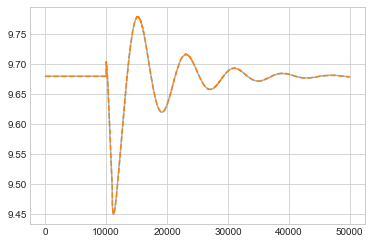

In [48]:
plt.plot(df.q.values, alpha=0.5)
plt.plot(pqs[:, 1], '--')

In [47]:
print(np.linalg.norm(df.p.values - pqs[:, 0]) / np.linalg.norm(df.p.values),
      np.linalg.norm(df.q.values - pqs[:, 1]) / np.linalg.norm(df.q.values),
      np.linalg.norm(df[['p', 'q']].values - pqs) / np.linalg.norm(df[['p', 'q']].values))

1.3013626056430666e-05 2.0098493310914605e-05 1.462567088937858e-05


## Testing learner

In [45]:
DIR = 'data_simple/std_params/R_e1'
injections = [os.path.join(DIR, fname) for fname in os.listdir(DIR)]

In [46]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])

In [63]:
lrn = Learner(injections, theta_true, stepsize=lambda k: 1/np.sqrt(k+1), eta=1e-4, mu=1, lbd=1e-3)

In [64]:
lrn.fit()

[   0]	objective	1.989279e+07	distance to solution	1.995615e+02
[-9.57816643e+03 -8.32029370e+02 -3.94151498e+06 -6.98245870e+03
 -3.92074893e+05  2.32196817e+03  6.27316316e+03 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  1.64824253e+03 -1.65024253e+03 -1.64948336e+03  1.64824253e+03]
[   1]	objective	7.832956e+04	distance to solution	4.441695e+02
[  3.09209659  -0.92292889 -39.5709394   -0.80122393  -6.05948052
  -0.96482639  -1.34646746  -0.99990001  -0.99990001  -0.99990001
  -0.99990001  -0.99990001 -14.8160754    8.90455868  12.42083254
 -14.8160754 ]
[   2]	objective	7.828000e+04	distance to solution	4.441715e+02
[  8.83802315  -0.92269475 -39.54550432  -0.80101216  -6.06607669
  -0.96666173  -1.34411819  -0.99982933  -0.99982933  -0.99982933
  -0.99982933  -0.99982933 -14.8411502    8.94071223  12.45049764
 -14.8411502 ]
[   3]	objective	7.828277e+04	distance to solution	4.441732e+02
[  8.7839104   -0.92265072 -39.54668482  -0.80095811  -6.

[  30]	objective	7.832316e+04	distance to solution	4.441942e+02
[  8.5624589   -0.92208714 -39.56428133  -0.80029313  -6.06553167
  -0.96562732  -1.34312413  -0.99904284  -0.99904284  -0.99904284
  -0.99904284  -0.99904284 -15.1869716    9.40152923  12.84914279
 -15.1869716 ]
[  31]	objective	7.832943e+04	distance to solution	4.441948e+02
[  7.06710719  -0.92212423 -39.56738304  -0.80029159  -6.0665576
  -0.96482798  -1.34331653  -0.99902493  -0.99902493  -0.99902493
  -0.99902493  -0.99902493 -15.19560105   9.41280876  12.85899825
 -15.19560105]
[  32]	objective	7.835917e+04	distance to solution	4.441953e+02
[  4.48440443  -0.92218845 -39.58241461  -0.80035418  -6.06195655
  -0.96411908  -1.34442209  -0.99900731  -0.99900731  -0.99900731
  -0.99900731  -0.99900731 -15.20634384   9.42557137  12.87096175
 -15.20634384]
[  33]	objective	7.836718e+04	distance to solution	4.441958e+02
[  8.35429732  -0.92203433 -39.58648447  -0.80035689  -6.0512508
  -0.96674329  -1.34462033  -0.99898995  

[  60]	objective	7.835442e+04	distance to solution	4.442072e+02
[  8.98339775  -0.92171602 -39.57837954  -0.79990072  -6.06160486
  -0.96563926  -1.34276255  -0.99859335  -0.99859335  -0.99859335
  -0.99859335  -0.99859335 -15.39553165   9.682128    13.08911214
 -15.39553165]
[  61]	objective	7.835253e+04	distance to solution	4.442076e+02
[  8.28758444  -0.92173335 -39.57734253  -0.79988217  -6.0648048
  -0.96497068  -1.34253855  -0.9985806   -0.9985806   -0.9985806
  -0.9985806   -0.9985806  -15.40126318   9.69005362  13.09570255
 -15.40126318]
[  62]	objective	7.835683e+04	distance to solution	4.442079e+02
[  6.94234403  -0.92176863 -39.57947035  -0.79988064  -6.06526664
  -0.9643602   -1.34277668  -0.99856795  -0.99856795  -0.99856795
  -0.99856795  -0.99856795 -15.40760153   9.69840526  13.10297487
 -15.40760153]
[  63]	objective	7.837021e+04	distance to solution	4.442083e+02
[  5.71811388  -0.92179672 -39.58621373  -0.79990405  -6.06368496
  -0.96393171  -1.34322536  -0.99855541  

KeyboardInterrupt: 

In [36]:
lrn.theta

array([ 2.30672457e+06,  1.74923602e+03,  3.67955181e+03,  4.53268445e+02,
        2.61528638e+05, -2.28219345e+02, -4.05245163e+02,  1.10000000e+00,
        1.10000000e+00,  1.10000000e+00,  1.10000000e+00,  1.10000000e+00,
       -1.05854362e+02,  1.08054362e+02,  1.08005589e+02, -1.05854362e+02])

## Loss surface

In [52]:
from tqdm import tqdm_notebook

In [49]:
def objective(theta):
    x0, _, c, pq0 = get_initial_values(P0=1997.9999999936396,
                                       Q0=967.9249699065775,
                                       V0=1.0,
                                       angle0=0.494677176989154,
                                       theta0=theta)

    xs = [x0]
    pqs = [pq0]
    for t in range(1, len(df)):
        x, pq = transition(xs[-1], df[['v', 'phi']].values[t], c, theta)
        xs.append(x)
        pqs.append(pq)
    return 0.5 * np.mean(np.sum((pqs - df[['p', 'q']].values) ** 2, axis=1))

In [50]:
proj = np.random.randn(2, 17)

In [51]:
x = np.linspace(-10, 10)
xx, yy = np.meshgrid(x, x)

In [54]:
values = np.zeros((50, 50))
for i, (x, y) in enumerate(zip(tqdm_notebook(xx), yy)):
    thetas = np.stack([x, y]).T @ proj
    for j, theta in enumerate(thetas):
        values[i, j] = objective(theta)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
sns.heatmap(np.log(values))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
xx, yy = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
ax.plot_surface(xx, yy, np.clip(np.log(values), -1.5, 10), cmap=cm.coolwarm)
ax.view_init(30, -70)